# GeoDistance check of OWDs - automatic

In [6]:
%matplotlib inline

import requests
import math
import datetime

try: import simplejson as json
except ImportError: import json

from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)

my_query = {}
OWDpos={}

As there is a lot of shards here, we have to use only the last ones

In [9]:
indices = es.cat.indices(index="network_weather-*", h="index", request_timeout=600).split('\n')
indices = [x for x in indices if x != '']
indices = [x.strip() for x in indices]

cday  = datetime.datetime.utcnow()
pday  = cday - datetime.timedelta(days=1)
ind1 = 'network_weather-%d.%d.%d' % (cday.year, cday.month, cday.day)
ind2 = 'network_weather-%d.%d.%d' % (pday.year, pday.month, pday.day)

print ('checking for indices:', ind1, ind2)

ind=[]
if ind1 in indices :
   ind.append(ind1)
if ind2 in indices and cday.hour<3:
   ind.append(ind2)

if len(ind)==0:
   print ('no current indices found. Aborting.')
   sys.exit(1)
else:
   print('will use indices:', ind)

checking for indices: network_weather-2017.1.9 network_weather-2017.1.8
will use indices: ['network_weather-2017.1.9']


In [10]:
query={
   "size": 0,
   "query": {
    "bool": {
      "must": [
        {"term": { "_type" : "latency"}}
      ]
#     , "filter" : {
#         'range': {'timestamp': {'gte': '20161111T000000+0000'}}
#       }
    }
   },
    "aggs" : {
      "src" : {
        "terms" : { "field" : "src", "size": 1000 },
        "aggs" : {
          "dest" : {
            "terms" : {"field" : "dest", "size": 1000},
            "aggs" : {
              "avgde" : {
                "avg" :{ "field" : "delay_mean" }
              }
          }
        }
      }
    }
    }        
}

res = es.search(index=ind, body=query, request_timeout=120)

In [11]:
def getServerLongLat(ip):
    
    if ip in OWDpos:
        return OWDpos[ip]
    
    try:
        req = requests.get("http://geoip.mwt2.org:4288/json/"+ip, None)
        res=req.json()
        lon=res['longitude']
        lat=res['latitude']
        pos=[lon,lat]
        OWDpos[ip]=pos
        return pos
    except:
        pass
#         print ("Can't determine coordinates. Trying next one.", ip)
        
    try:
        req = requests.get("http://freegeoip.net/json/"+ip, None)
        res=req.json()
        lon=res['longitude']
        lat=res['latitude']
        pos=[lon,lat]
        OWDpos[ip]=pos
        return pos
    except:
        print ("Can't determine coordinates", ip)
        
def getDistance(ip1,ip2):
    p1=getServerLongLat(ip1)
    p2=getServerLongLat(ip2)
    if not p1 or not p2: return 0.0
    dlon = math.radians(p1[0] - p2[0])
    dlat = math.radians(p1[1] - p2[1])
    a = pow(math.sin(dlat/2),2) + math.cos(math.radians(p2[1])) * math.cos(math.radians(p1[1])) * pow(math.sin(dlon/2),2)
    c = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) )
    d = 6373 * c # 6373 is the radius of the Earth in km
    return d  

  Creating DataFrame with all the data        

In [12]:
ser = res['aggregations']['src']['buckets']
count=10
src=[]
dest=[]
docs=[]
dist=[]
owd=[]
for s in ser:
    des=s['dest']['buckets']
    for d in des:
        delay = d['avgde']['value']
        distance = getDistance(s['key'], d['key'])
        
        src.append( s['key'])
        dest.append(d['key'])
        docs.append(d['doc_count'])
        dist.append(distance)
        owd.append( delay)
        
        if count>0:
            count -= 1
            print ( s['key'], '->', d['key'], '\tdocs:', d['doc_count'], '\tAvg OWD: {:.2f}   Dist:{:.1f}'.format(delay, distance))
        

131.169.98.30 -> 129.93.239.148 	docs: 909 	Avg OWD: 66.99   Dist:7411.7
131.169.98.30 -> 130.246.176.109 	docs: 893 	Avg OWD: 15.50   Dist:792.5
131.169.98.30 -> 148.187.64.25 	docs: 858 	Avg OWD: 14.36   Dist:842.4
131.169.98.30 -> 192.111.108.112 	docs: 858 	Avg OWD: 61.65   Dist:7263.4
131.169.98.30 -> 193.48.101.41 	docs: 858 	Avg OWD: 32.60   Dist:745.1
131.169.98.30 -> 202.122.32.170 	docs: 809 	Avg OWD: 139.10   Dist:7473.1
131.169.98.30 -> 192.101.107.152 	docs: 740 	Avg OWD: 87.88   Dist:7922.4
131.169.98.30 -> 144.206.237.142 	docs: 572 	Avg OWD: 31.60   Dist:1781.8
131.169.98.30 -> 192.54.207.250 	docs: 536 	Avg OWD: 27.43   Dist:745.1
131.169.98.30 -> 129.15.40.231 	docs: 436 	Avg OWD: 70.41   Dist:7943.6


In [13]:
data = pd.DataFrame({'src':src, 'dest':dest, 'docs':docs, 'owd':owd, 'dist':dist})
print(data.shape)
data.head()

(4876, 5)


,dest,dist,docs,owd,src
0,129.93.239.148,7411.681188,909,66.986916,131.169.98.30
1,130.246.176.109,792.532551,893,15.496354,131.169.98.30
2,148.187.64.25,842.445650,858,14.360855,131.169.98.30
3,192.111.108.112,7263.372082,858,61.651042,131.169.98.30
4,193.48.101.41,745.122152,858,32.603765,131.169.98.30


In [14]:
#cleaning up ones with not many measurements
data=data[data.docs > 100]
print(data.shape)
data.describe()

(4832, 5)


,dist,docs,owd
count,4832.000000,4832.000000,4832.000000
mean,4545.763649,288.128104,49.877098
std,3923.193336,118.493620,41.134804
min,0.000000,101.000000,-11.053989
25%,965.546279,255.000000,16.829392
50%,2808.827385,258.000000,39.082251
75%,7765.850678,260.000000,73.219556
max,19065.338076,2566.000000,234.649242


For servers that appear in at least 2 links, calculate abs of difference of mean of forward and backward OWDs. Return as sorted dataframe.

In [15]:
def differentialOWDs(data):

    # first group by src and dest 
    groupedBySrc = data.groupby('src')
    groupedByDest = data.groupby('dest')
    #groupedBySrc.head()
    
    src=[]
    fwd=[]
    rew=[]
    for name, group in groupedBySrc:
       #print(name, group.owd.mean())
       if group.owd.count()>2:
            src.append(name)
            fwd.append(group.owd.mean())
    fwdDF=pd.DataFrame({'fwd':fwd},index=src)
    fwdDF.head()
    dst=[]
    for name, group in groupedByDest:
       #print(name, group.owd.mean())
       if group.owd.count()>2:
            dst.append(name)
            rew.append(group.owd.mean())
    rewDF=pd.DataFrame({'rew':rew},index=dst)
    rewDF.head()

    TWD=pd.concat([fwdDF,rewDF], axis=1)

    TWD['diff']=TWD.fwd-TWD.rew
    TWD['diff']=TWD['diff'].abs()
    TWD=TWD.dropna()
    TWD=TWD.sort_values('diff',ascending=False)
    
    n, bins, patches = plt.hist(TWD['diff'].tolist(), bins=np.logspace(0.1, 4.0, 50), histtype='stepfilled')
    plt.gca().set_xscale("log")
    plt.show()
    
    return TWD

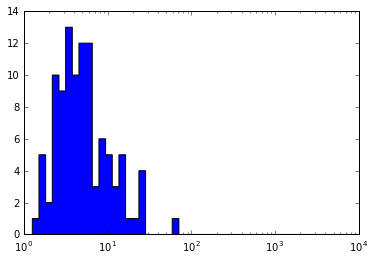

,fwd,rew,diff
192.101.161.186,58.869907,-1.304315,60.174222
134.158.132.200,34.873445,62.975448,28.102004
2401:de00::302,151.878934,125.595557,26.283377
202.13.203.129,64.295513,89.939941,25.644428
134.158.150.245,34.494568,9.235002,25.259566


In [16]:
# Look for the worst
dOWDs = differentialOWDs(data)
dOWDs.head()

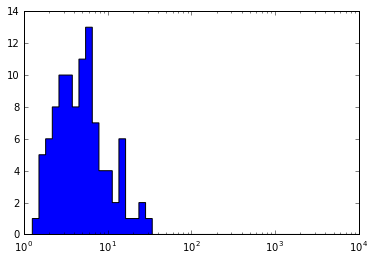

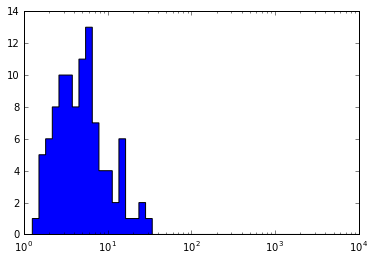

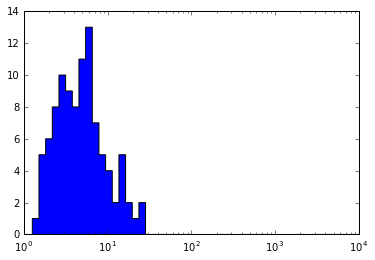

,fwd,rew,diff
2401:de00::302,151.878934,125.595557,26.283377
202.13.203.129,64.295513,89.939941,25.644428
195.19.226.144,14.494227,34.917205,20.422978
132.230.202.235,32.467099,13.620132,18.846967
134.158.123.183,45.768289,27.959024,17.809265


In [22]:
#remove worst
data=data[data.src!='192.101.161.186']
data=data[data.dest!='192.101.161.186']

dOWDs = differentialOWDs(data)
dOWDs.head()

data=data[data.src!='134.158.132.200']
data=data[data.dest!='134.158.132.200']

dOWDs = differentialOWDs(data)
dOWDs.head()

data=data[data.src!='134.158.150.245']
data=data[data.dest!='134.158.150.245']

dOWDs = differentialOWDs(data)
dOWDs.head()

# data=data[data.src!='192.41.236.35']
# data=data[data.dest!='192.41.236.35']

# dOWDs = differentialOWDs(data)
# dOWDs.head(10)

In [23]:
data[data.src=='2401:de00::302']

,dest,dist,docs,owd,src
4624,2001:660:5009:9:193:48:99:76,8171.557708,634,160.948250,2401:de00::302
4625,2001:630:3c1:638::d546,7912.866740,471,156.297044,2401:de00::302
4626,2001:630:80:2fd::aaff:59f0,7953.061449,259,159.423456,2401:de00::302
4627,2001:660:3031:110:ffff::221,8171.557708,259,157.416430,2401:de00::302
4628,2a01:56c0:4033::26,7912.866740,259,152.400289,2401:de00::302
4629,2001:638:700:1062::1:1e,7444.531047,246,161.706436,2401:de00::302
4630,2607:f720:1700:1b30::28,11593.520868,246,86.528552,2401:de00::302
4631,2001:948:48:1::f501:1,6626.311293,236,176.626093,2401:de00::302
4632,2001:630:22:1004:800:ff:fe00:28,7912.866740,192,155.563856,2401:de00::302


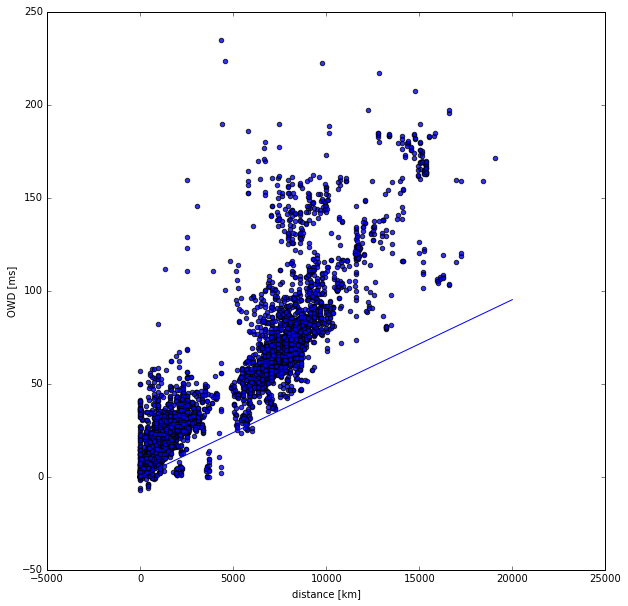

In [24]:
plt.figure(figsize=[10, 10])
plt.scatter( data.dist, data.owd ,alpha=0.8)
x = np.linspace(0, 20000)
y = x/(300*0.7)
plt.plot(x, y, '-')
plt.xlabel('distance [km]')
plt.ylabel('OWD [ms]')
plt.show()

In [25]:
# look for very low speeds
data1=data[data.dist>0]
data1['speed']=data1.dist/data1.owd/300
grouped = data1.groupby('src')
grouped.agg({'dist' : 'mean', 'speed':'mean', 'owd' : ['mean','count'] })
grouped.head()

src=[]
spd=[]
for name, group in grouped:
    #print(name, group.owd.mean())
    src.append(name)
    spd.append(group.speed.mean())
spdDF=pd.DataFrame({'spd':spd},index=src)
spdDF=spdDF.sort_values('spd')
spdDF.head()


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,spd
212.193.96.29,-6.721186
188.185.224.217,0.002350
198.124.252.126,0.004533
198.124.252.97,0.005862
2001:630:441:905::d2,0.018747


In [ ]:
data[data.src=='128.211.143.3']

In [ ]:
data[data.src=='132.230.202.235']